In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [4]:
excel_file = pd.read_excel('/content/output.xlsx')
data = excel_file.to_csv('/content/output.csv', index=False)
df2 = pd.read_csv('/content/output.csv')
df2.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [7]:
X = df2.drop('y', axis=1)  # Assuming 'y' is your target column
y = df2['y']

X.isna().sum()


,0
age,0
job,0
marital,0
education,0
default,0
balance,0
housing,0
loan,0
contact,0
day,0


In [8]:
df2['y'] = df2['y'].map({'yes': 1, 'no': 0})

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split function for that with random_state=1

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=1)  # 60% for train
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=1)  # Remaining 40% split into 20%/20%

In [13]:
from sklearn.metrics import roc_auc_score

numerical_features = X_train.select_dtypes(include=['number']).columns

roc_auc_scores = {}
for feature in numerical_features:
    roc_auc = roc_auc_score(y_train, X_train[feature])
    roc_auc_scores[feature] = roc_auc

for feature, score in roc_auc_scores.items():
    print(f"Feature: {feature}, ROC AUC: {score}")


Feature: age, ROC AUC: 0.48748941184002925
Feature: balance, ROC AUC: 0.5916931412945473
Feature: day, ROC AUC: 0.470872401535104
Feature: duration, ROC AUC: 0.8128648066681694
Feature: campaign, ROC AUC: 0.42575522982599967
Feature: pdays, ROC AUC: 0.5897967289320412
Feature: previous, ROC AUC: 0.5986704105715122


In [15]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression


vectorizer = DictVectorizer(sparse=False)

X_train_dict = X_train.to_dict(orient='records')
X_train_encoded = vectorizer.fit_transform(X_train_dict)


In [16]:
model = LogisticRegression(penalty='l1', C=1.0, solver='liblinear')
model.fit(X_train_encoded, y_train)


LogisticRegression(penalty='l1', solver='liblinear')

In [19]:
X_val_dict = X_val.to_dict(orient='records')

X_val_encoded = vectorizer.transform(X_val_dict)

y_pred_proba = model.predict_proba(X_val_encoded)[:, 1]

auc = roc_auc_score(y_val, y_pred_proba)

print(f"AUC on validation set: {auc:.3f}")

AUC on validation set: 0.901


In [21]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

thresholds = np.arange(0.0, 1.01, 0.01)
precision_scores = []
recall_scores = []

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred)
    precision_scores.append(precision)
    recall_scores.append(recall)

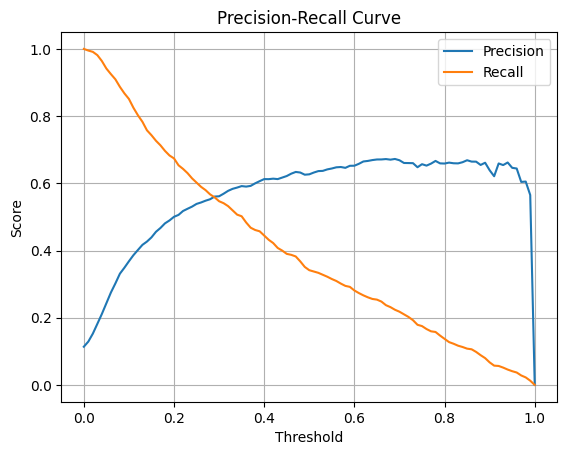

In [22]:
import matplotlib.pyplot as plt

plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

Q 4

In [23]:
from sklearn.metrics import f1_score

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for threshold in thresholds:
    y_pred = (y_pred_proba >= threshold).astype(int)
    f1 = f1_score(y_val, y_pred)
    f1_scores.append(f1)

max_f1 = max(f1_scores)  # Find the maximum F1 score
max_f1_threshold = thresholds[f1_scores.index(max_f1)]  # Find the corresponding threshold

print(f"Maximal F1: {max_f1:.3f}")
print(f"Threshold for maximal F1: {max_f1_threshold:.2f}")

Maximal F1: 0.574
Threshold for maximal F1: 0.20


Q 5

In [24]:

from sklearn.model_selection import KFold


def train_and_evaluate(X, y, model, vectorizer, n_splits=5, random_state=1):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    auc_scores = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        X_train_dict = X_train.to_dict(orient='records')
        X_val_dict = X_val.to_dict(orient='records')

        X_train_encoded = vectorizer.fit_transform(X_train_dict)
        X_val_encoded = vectorizer.transform(X_val_dict)

        model.fit(X_train_encoded, y_train)
        y_pred_proba = model.predict_proba(X_val_encoded)[:, 1]
        auc = roc_auc_score(y_val, y_pred_proba)
        auc_scores.append(auc)

    return auc_scores

auc_scores = train_and_evaluate(X, y, model, vectorizer)

print(f"AUC scores for 5 folds: {auc_scores}")
print(f"Mean AUC: {np.mean(auc_scores):.3f}")

AUC scores for 5 folds: [0.9081402179287827, 0.8995027520640481, 0.9050192316547383, 0.9138762572095905, 0.90766972897272]
Mean AUC: 0.907


In [25]:

def train_and_evaluate(X_train, y_train, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    auc_scores = []

    vectorizer = DictVectorizer(sparse=False)

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

        X_train_fold_dict = X_train_fold.to_dict(orient='records')
        X_val_fold_dict = X_val_fold.to_dict(orient='records')

        X_train_fold_encoded = vectorizer.fit_transform(X_train_fold_dict)
        X_val_fold_encoded = vectorizer.transform(X_val_fold_dict)

        model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
        model.fit(X_train_fold_encoded, y_train_fold)

        y_pred_proba = model.predict_proba(X_val_fold_encoded)[:, 1]
        auc = roc_auc_score(y_val_fold, y_pred_proba)
        auc_scores.append(auc)

    return auc_scores

auc_scores = train_and_evaluate(X_train, y_train)

print(f"AUC scores for 5 folds: {auc_scores}")
print(f"Mean AUC: {np.mean(auc_scores):.3f}")
print(f"Standard Deviation of AUC: {np.std(auc_scores):.3f}")

AUC scores for 5 folds: [0.9106544153294127, 0.913491642096428, 0.9031671932491432, 0.9053321472928066, 0.9112264710517832]
Mean AUC: 0.909
Standard Deviation of AUC: 0.004


Q 6

In [26]:
def train_and_evaluate_with_c(X_train, y_train, C_values, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    best_C = None
    best_auc = 0

    for C in C_values:
        auc_scores = []
        for train_index, val_index in kf.split(X_train):
            X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
            y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]

            vectorizer = DictVectorizer(sparse=False)
            X_train_fold_encoded = vectorizer.fit_transform(X_train_fold.to_dict(orient='records'))
            X_val_fold_encoded = vectorizer.transform(X_val_fold.to_dict(orient='records'))

            model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
            model.fit(X_train_fold_encoded, y_train_fold)

            y_pred_proba = model.predict_proba(X_val_fold_encoded)[:, 1]
            auc = roc_auc_score(y_val_fold, y_pred_proba)
            auc_scores.append(auc)

        mean_auc = np.mean(auc_scores)
        if mean_auc > best_auc:
            best_auc = mean_auc
            best_C = C

    return best_C, best_auc

C_values = [0.000001, 0.001, 1]
best_C, best_auc = train_and_evaluate_with_c(X_train, y_train, C_values)

print(f"Best C: {best_C}")
print(f"Best AUC: {best_auc:.3f}")

Best C: 1
Best AUC: 0.909
